In [95]:
import torch
import os 

import traci
import sumo_rl
os.environ['SUMO_HOME'] = '/opt/homebrew/opt/sumo/share/sumo'


In [96]:
import torch.nn as nn

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [5]:
from sumo_rl.environment.env import env, parallel_env, SumoEnvironment
from ray.tune import register_env
from ray.rllib.env.wrappers.pettingzoo_env import ParallelPettingZooEnv
from ray.rllib.env.wrappers.multi_agent_env_compatibility import MultiAgentEnvCompatibility

from environment.envs import RealMultiAgentSumoEnv
from environment.observation import Grid2x2ObservationFunction, EntireObservationFunction
from environment.reward_functions import combined_reward

env_folder = "data/2x2grid"

multi_agent_env = parallel_env(    
        net_file = os.path.join(env_folder, "2x2.net.xml"),
        route_file = os.path.join(env_folder, "2x2.rou.xml"),
        reward_fn = combined_reward,
        observation_class = EntireObservationFunction, 
        out_csv_name="outputs/2x2grid/ppo", 
        num_seconds=1000,
        add_per_agent_info=True,
        add_system_info=True,
        single_agent=False)

/Users/loveen/.pyenv/versions/3.9.10/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-01-22 15:25:16,270	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-01-22 15:25:16,391	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


NameError: name 'os' is not defined

In [ ]:
multi_agent_env.possible_agents

['1', '2', '5', '6']

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch 

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.soft_max = nn.Softmax()
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        self.linear_network = nn.Sequential(
            nn.Linear(self.state_dim,100), # 2 - 3 layers. 84 neurones because each policy absorbs the entire observation space 
            nn.ReLU(),
            nn.Linear(100,100), # 100 neurones to start with - neurones should be approx within range of no. features
            nn.ReLU(),
            nn.Linear(100,self.action_dim), # 4 represents the phases each intersection entails. 
        )

    def forward(self, x):
        if type(x)==dict:
            arr = np.array(x.values())
            x = torch.from_numpy(arr)
            print(x)
        if type(x)==np.ndarray:
            x = torch.from_numpy(arr)
        output = self.linear_network(x.float())
        logits = self.soft_max(output)
        return logits

In [122]:
class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.soft_max = nn.Softmax()
        self.state_dim = state_dim
        
        self.linear_network = nn.Sequential(
            nn.Linear(self.state_dim,100), # 2 - 3 layers. 84 neurones because each policy absorbs the entire observation space 
            nn.ReLU(),
            nn.Linear(100,100), # 100 neurones to start with - neurones should be approx within range of no. features
            nn.ReLU(),
            nn.Linear(100,1), # outputs the value of being in a particular state 
        )

    def forward(self, x):
        if type(x)==dict:
            arr = np.array(x.values())
            x = torch.from_numpy(arr)
        if type(x)==np.ndarray:
            x = torch.from_numpy(x)
        output = self.linear_network(x.float())
        return output 

In [123]:
def convert_arr_to_tensor(obs:np.ndarray):
    return torch.from_numpy(obs)

def get_agent_observation_as_tensor(all_agents_obs:dict, agent_id:str):
    '''Takes in entire observations, returning observations for particular agent in tensor form'''
    agent_obs = all_agents_obs[agent_id]
    return convert_arr_to_tensor(agent_obs)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from copy import deepcopy
import logging 
logging.basicConfig(filename='train_logs.log', level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

class PPO:
    def __init__(self, multi_agent_par_env, state_dim, action_dim, lr=1e-3, discount=0.99, clip_epsilon=0.2):
        self.agents_neuralnetwork = [self._init_agent(state_dim, action_dim, lr) for _ in range(multi_agent_par_env.max_num_agents)]
        self.discount = discount
        self.clip_epsilon = clip_epsilon
        self.multi_agent_env = multi_agent_par_env
        # self.entropy_coeff

        self.agent_ids = self.multi_agent_env.possible_agents # list 
        self.num_agents = self.multi_agent_env.max_num_agents
        self.state_dim = state_dim #84
 
        self.update_agents_neuralnetwork_old() # dont think you even need this. 

    def _init_agent(self, state_dim, action_dim, lr):
        policy_net = PolicyNetwork(state_dim, action_dim)
        value_net = ValueNetwork(state_dim)
        policy_optimizer = optim.Adam(policy_net.parameters(), lr=lr)
        value_optimizer = optim.Adam(value_net.parameters(), lr=lr)
        return {"policy": policy_net, "value": value_net, "policy_opt": policy_optimizer, "value_opt": value_optimizer}

    def sample_policy_action(self, agent_i:int, observations) -> torch.Tensor :
        return self.agents_neuralnetwork[agent_i]['policy'](observations)
    
    def sample_policy_actions(self, observations:dict) -> dict:
        '''Takes in observations of all agents, returning the action vectors for use in environment'''
        return {id: self.sample_policy_action(i, observations[id]) for i, id in enumerate(self.agent_ids)}

    def generate_value(self, agent_i, agent_observations:torch.Tensor) -> torch.Tensor: 
        value = self.agents_neuralnetwork[agent_i]['value'](agent_observations)
        return value.detach().numpy()

    def generate_values(self, observations) -> np.ndarray: 
        ''''Generates values for all agents when given all observations'''
        return np.array([self.generate_value(i, agent_observations) for i, agent_observations in enumerate(self.agent_ids, observations)])
    
    def _generate_trajectory_np(self, observations:dict, no_timesteps:int) -> tuple:
        '''Expecting observations for all agents from multi-agent parallel environment setup.
        Ensure to pass in the current observations of all agents in env'''

        observation_trajectories = np.zeros((self.num_agents, no_timesteps, self.state_dim))
        action_trajectories = np.zeros((self.num_agents, no_timesteps))
        reward_trajectories = np.zeros((self.num_agents, no_timesteps))
        pred_prob_trajectories = np.zeros((self.num_agents, no_timesteps))

        for t in range(no_timesteps):

            agents_actions = {agent_id:None for agent_id in self.agent_ids} # initialise

            print('start of outer loop agents actions: ', agents_actions)

            for i, id in enumerate(self.agent_ids):
                # get immediate action from policy network
                agent_obs = get_agent_observation_as_tensor(observations, agent_id=id)
                # print(agent_obs)
                pred_probs = self.sample_policy_action(i, agent_obs) # Each agent will sample from its own policy
                action = pred_probs.argmax()
                print("inner loop: ", action)

                observation_trajectories[i][t] = agent_obs[t].numpy()
                action_trajectories[i][t] = action
                pred_prob_trajectories[i][t] = pred_probs.max().detach().numpy()

                agents_actions[id]= int(action) # update this, as next it will go in the step() func
            
            print('end of inner loop agents actions: ', agents_actions)

            observations, rewards, terminations, truncations, infos = self.multi_agent_env.step(agents_actions) # takes in a dictionary of all agents + their corresponding actions
            
            # store rewards recieved after taking step 
            for i, id in enumerate(self.agent_ids):
                reward_trajectories[i][t] = rewards[id]

        return observation_trajectories, action_trajectories, pred_prob_trajectories, reward_trajectories

    def generate_episodes_np(self, observations, no_episodes, no_timesteps) -> tuple:
        '''Generate multiple episodes returning obs, actions, rewards, advantages tensors over all the episodes'''

        ep_obs = np.zeros((self.num_agents, no_episodes, no_timesteps, self.state_dim))
        ep_actions = np.zeros((self.num_agents, no_episodes, no_timesteps))
        ep_rewards = np.zeros((self.num_agents, no_episodes, no_timesteps))

        ep_returns = np.zeros((self.num_agents, no_episodes, no_timesteps))
        ep_pred_values = np.zeros((self.num_agents, no_episodes, no_timesteps))
        ep_advantages = np.zeros((self.num_agents, no_episodes, no_timesteps)) # returns - pred_values

        ep_pred_probs = np.zeros((self.num_agents, no_episodes, no_timesteps))

        for ep_i in range(no_episodes): 
            # generate a trajectory over t timesteps 
            observations_trajec, actions_trajec, pred_prob_trajec, rewards_trajec = self._generate_trajectory_np(observations, no_timesteps)

            for agent_i, agent_id in enumerate(self.agent_ids):

                reversed_returns =  np.zeros((no_timesteps))
                reversed_pred_values = np.zeros((no_timesteps))

                reversed_advantages = np.zeros((no_timesteps)) # returns - pred_values(V(s))

                running_returns = 0

                for t in reversed(range(no_timesteps)): # t is reversed here 
                    
                    # calculate returns from rewards 
                    rewards = rewards_trajec[agent_i][t]
                    running_returns += rewards # we have not implemented a 1 step return, currently it consists of entire return. 
                    reversed_returns[t] = running_returns 

                    # calculate predicted values from value network at time t 
                    agent_observations_t = observations_trajec[agent_i][t]
                    agent_pred_value = self.generate_value(agent_i, agent_observations_t) # simple forward pass in network to calculate value of state. 

                    # calculate advantage at time t 
                    advantage = running_returns - agent_pred_value

                    reversed_advantages[t] = advantage
                    reversed_pred_values[t] = agent_pred_value

                # reverse all arrays
                advantages = reversed_advantages[::-1]
                returns = reversed_returns[::-1] 
                pred_values = reversed_pred_values[::-1]

                # append [t] arrays to episodic arrays
                ep_advantages[agent_i][ep_i] = advantages 
                ep_returns[agent_i][ep_i] = returns
                ep_pred_values[agent_i][ep_i] = pred_values

                # append other data to large episode tensor
                ep_obs[agent_i][ep_i] = observations_trajec[agent_i]
                ep_actions[agent_i][ep_i] = actions_trajec[agent_i]
                ep_rewards[agent_i][ep_i] = rewards_trajec[agent_i]
                ep_pred_probs[agent_i][ep_i] = pred_prob_trajec[agent_i]

        return ep_obs, ep_actions, ep_pred_probs, ep_rewards, ep_returns, ep_pred_values, ep_advantages

    def __compute_policy_loss(self, old_log_probs, new_log_probs, advantages):
        '''Takes sequence of log_probs and advantages in tensors, calculates J(0) which is the prob ratios * advantages'''

        # Calculate the ratio of new and old probabilities
        ratios = torch.exp(new_log_probs - old_log_probs)

        # Calculate surrogate loss
        surr1 = ratios * advantages
        surr2 = torch.clamp(ratios, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * advantages
        policy_loss = -torch.min(surr1, surr2).mean()  # Negative because we perform gradient ascent

        return policy_loss
    
    def __compute_value_loss(self, actual_returns, predicted_values) -> torch.Tensor:

        # Mean squared error loss between predicted and actual returns
        value_loss = F.mse_loss(predicted_values, actual_returns)

        return value_loss
    
    def update_agents_neuralnetwork_old(self):
        '''This function does a deep copy of the current agent policies, returning dictionaries'''

        self.agents_neuralnetwork_old = [{"policy": deepcopy(self.agents_neuralnetwork[i]['policy']), "value": deepcopy(self.agents_neuralnetwork[i]['value']), \
                                         "policy_opt": deepcopy(self.agents_neuralnetwork[i]['policy_opt']), \
                                            "value_opt": deepcopy(self.agents_neuralnetwork[i]['value_opt'])}\
                                         for i in range(self.num_agents)]


    def update_network(self, agent_enumer, observations_batch, pred_probs_batch, returns_batch, pred_values_batch, advantages_batch):
        '''Expects data in tensor format, returns in tensor format'''
    
        agent_i, agent_id = agent_enumer # unwrap tuple(int,str)

        old_pred_probs_batch = torch.zeros((len(observations_batch)), dtype=float)
        
        # agent_neuralnetwork_old = self.agents_neuralnetwork_old[agent_i]
        agent_neuralnetwork_old = self.agents_neuralnetwork[agent_i]

        # calc predicted probability from the old network - do it for [obs1, obs2, obs3, ...]
        for i, observations in enumerate(observations_batch):
            # print(i, observations)
            old_pred_probs_batch[i] = agent_neuralnetwork_old['policy'](observations).max()
        
        policy_loss = self.__compute_policy_loss(old_pred_probs_batch, pred_probs_batch, advantages_batch)  
        
        # Backpropagate policy loss
        policy_optimiser = self.agents_neuralnetwork[agent_i]['policy_opt']
        
        policy_optimiser.zero_grad()
        policy_loss.backward()
        policy_optimiser.step()

        # Calculate value loss
        value_loss = self.__compute_value_loss(returns_batch, pred_values_batch)

        # Backpropagate value loss
        value_optimiser = self.agents_neuralnetwork[agent_i]['value_opt']
        
        value_optimiser.zero_grad()
        value_loss.backward()
        value_optimiser.step()

        return policy_loss, value_loss 

    def train(self, no_episodes, no_timesteps, minibatch_size, no_epochs):
        ''''MA Training happens here. Updates the network, keeping track of metrics throughout'''
        logging.debug("Entering train()")
        
        train_info_index = 0

        batch_size = no_episodes * no_timesteps # e.g. 4*100*100 -> 40000 this is due to flattening the vectors.  

        sampler_size = batch_size // minibatch_size # from predicting size 

        total_no_losses = no_epochs * sampler_size

        # All training data will go here 
        train_info = {id:{'policy_loss': np.zeros((total_no_losses)), 'value_loss':np.zeros((total_no_losses))} for id in self.agent_ids}

        observations, truncations = self.multi_agent_env.reset()

        for epoch_i in range(no_epochs):
            
            # logging.debug("Epoch no", epoch_i)

            ep_obs, ep_actions, ep_pred_probs, ep_rewards, \
                ep_returns, ep_pred_values, ep_advantages = self.generate_episodes_np(observations, no_episodes, no_timesteps)
            
            # logging.debug("Generate_episodes() returns", 'ep_obs_shape', np.shape(ep_obs), \
            #                                              'ep_actions_shape', np.shape(ep_actions), \
            #                                              'ep_pred_probs_shape',  np.shape(ep_pred_probs), \
            #                                              'ep_rewards_shape',  np.shape(ep_rewards), \
            #                                              'ep_returns', np.shape(ep_returns), \
            #                                               'ep_pred_values_shape', np.shape(ep_pred_values), \
            #                                               'ep_advantages_shape', np.shape(ep_advantages))

            logging.debug("Epoch no", epoch_i)
            # episodic_obs (no_agents, no_epi, time_steps, dim)

            subset_sampler = SubsetRandomSampler(range(batch_size)) # random assort integers from 1 - 84, put in list [3, 4, 9, 84, ...]
            sampler = BatchSampler(subset_sampler, minibatch_size, True) # divide this list into batches of size minibatch_size [1, 3, ..], [54, 76, 2..]

            for agent_i, agent_id in enumerate(self.agent_ids): # update network for every agent
                
                logging.debug("loop over agent: ", agent_i)

                agent_obs = ep_obs[agent_i].reshape(-1,84)

                agent_returns = ep_returns[agent_i].reshape(-1) # (no_epi * time_steps) 1dim
                agent_pred_values = ep_pred_values[agent_i].reshape(-1)

                agent_pred_probs = ep_pred_probs[agent_i].reshape(-1) # (no_epi, time_steps, dim) -> (no_epi*timesteps, dim)
                agent_advantages = ep_advantages[agent_i].reshape(-1)

                for k, indices in enumerate(sampler):
                
                    agent_obs_batch = torch.tensor(agent_obs[indices]) # shape = (len(indices), 84)

                    agent_pred_probs_batch = torch.tensor(agent_pred_probs[indices], requires_grad=True)
                    agent_advantages_batch = torch.tensor(agent_advantages[indices], requires_grad=True)

                    agent_returns_batch = torch.tensor(agent_returns[indices], requires_grad=True)
                    agent_pred_values_batch = torch.tensor(agent_pred_values[indices], requires_grad=True)

                    policy_loss, value_loss = self.update_network((agent_i, agent_id), agent_obs_batch, agent_pred_probs_batch, \
                                                                   agent_returns_batch, agent_pred_values_batch, agent_advantages_batch,)
                    
                    train_info[agent_id]['policy_loss'][train_info_index+k] = policy_loss
                    train_info[agent_id]['value_loss'][train_info_index+k] = value_loss

            train_info_index += len(sampler)

            # observations = {agent_id:ep_obs[agent_i][-1][-1] for agent_i, agent_id in enumerate(self.agent_ids)}
        return train_info   

In [4]:
ppo_algo = PPO(multi_agent_env, 84, 4)

NameError: name 'multi_agent_env' is not defined

In [134]:
multi_agent_env.reset()
train_info = ppo_algo.train(50, 30, 10, 1)

Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 34934ms, vehicles TOT 167 ACT 60 BUF 249)            
 Retrying in 1 seconds


2024-01-22 00:00:57,649 - DEBUG - Entering train()


Step #0.00 (0ms ?*RT. ?UPS, TraCI: 54ms, vehicles TOT 0 ACT 0 BUF 0)                     
 Retrying in 1 seconds


--- Logging error ---
Traceback (most recent call last):
  File "/Users/loveen/.pyenv/versions/3.9.10/lib/python3.9/logging/__init__.py", line 1083, in emit
    msg = self.format(record)
  File "/Users/loveen/.pyenv/versions/3.9.10/lib/python3.9/logging/__init__.py", line 927, in format
    return fmt.format(record)
  File "/Users/loveen/.pyenv/versions/3.9.10/lib/python3.9/logging/__init__.py", line 663, in format
    record.message = record.getMessage()
  File "/Users/loveen/.pyenv/versions/3.9.10/lib/python3.9/logging/__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/Users/loveen/.pyenv/versions/3.9.10/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/loveen/.pyenv/versions/3.9.10/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/loveen/.pyenv/versions/3.9.10/lib/python3.9/site

start of outer loop agents actions:  {'1': None, '2': None, '5': None, '6': None}
inner loop:  tensor(2)
inner loop:  tensor(2)
inner loop:  tensor(0)
inner loop:  tensor(3)
end of inner loop agents actions:  {'1': 2, '2': 2, '5': 0, '6': 3}
start of outer loop agents actions:  {'1': None, '2': None, '5': None, '6': None}
inner loop:  tensor(2)
inner loop:  tensor(2)
inner loop:  tensor(0)
inner loop:  tensor(3)
end of inner loop agents actions:  {'1': 2, '2': 2, '5': 0, '6': 3}
start of outer loop agents actions:  {'1': None, '2': None, '5': None, '6': None}
inner loop:  tensor(2)
inner loop:  tensor(2)
inner loop:  tensor(0)
inner loop:  tensor(3)
end of inner loop agents actions:  {'1': 2, '2': 2, '5': 0, '6': 3}
start of outer loop agents actions:  {'1': None, '2': None, '5': None, '6': None}
inner loop:  tensor(2)
inner loop:  tensor(2)
inner loop:  tensor(0)
inner loop:  tensor(3)
end of inner loop agents actions:  {'1': 2, '2': 2, '5': 0, '6': 3}
start of outer loop agents actio

KeyError: '1'

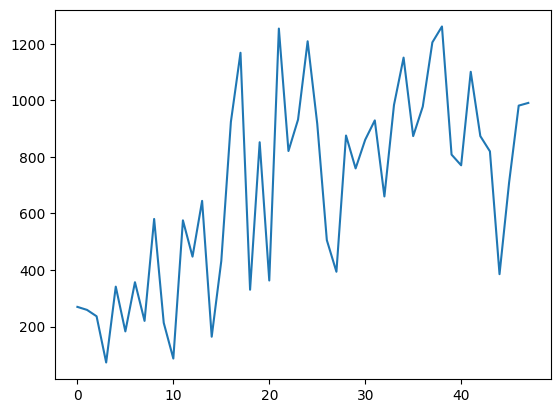

48

In [88]:
policy_loss = [train_info[id]['policy_loss'] for id in multi_agent_env.possible_agents]
value_loss = [train_info[id]['value_loss'] for id in multi_agent_env.possible_agents]

import matplotlib.pyplot as plt 

plt.plot(policy_loss[0])
# plt.legend([1,2,3,4])
plt.show()

len(policy_loss[0])

In [64]:
multi_agent_env_2 = parallel_env(    
        net_file = os.path.join(env_folder, "2x2.net.xml"),
        route_file = os.path.join(env_folder, "2x2.rou.xml"),
        reward_fn = combined_reward,
        observation_class = EntireObservationFunction, 
        out_csv_name="outputs/2x2grid/ppo", 
        num_seconds=1000,
        add_per_agent_info=True,
        add_system_info=True,
        single_agent=False)

ppo_algo = PPO(multi_agent_env_2, 84, 4)
train_info = ppo_algo.train(4, 10, 15, 3)

 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 0 ACT 0 BUF 0)                     
 Retrying in 1 seconds
start of outer loop agents actions:  {'1': None, '2': None, '5': None, '6': None}
inner loop:  tensor(1)
inner loop:  tensor(3)
inner loop:  tensor(2)
inner loop:  tensor(1)
end of inner loop agents actions:  {'1': 1, '2': 3, '5': 2, '6': 1}
start of outer loop agents actions:  {'1': None, '2': None, '5': None, '6': None}
inner loop:  tensor(1)
inner loop:  tensor(3)
inner loop:  tensor(2)
inner loop:  tensor(1)
end of inner loop agents actions:  {'1': 1, '2': 3, '5': 2, '6': 1}
start of outer loop agents actions:  {'1': None, '2': None, '5': None, '6': None}
inner loop:  tensor(1)
inner loop:  tensor(3)
inner loop:  tensor(2)
inner loop:  tensor(1)
end of inner loop agents actions:  {'1': 1, '2': 3, '5': 2, '6': 1}
start of outer loop agents actions:  {'1': None, '2': None, '5': None, '6': None}
inner loop:  tensor(0)
inner loop:  tensor(3)
inner loop

IndexError: index 4 is out of bounds for dimension 0 with size 4

In [ ]:
agents_neuralnetwork = [2, 5, 6, 8]

ppo_algo = PPO(multi_agent_env, 84, 4)


from copy import deepcopy

# h = {id: action for i, (id, action) in enumerate(zip(['1', '4', '6', '7'], agents_neuralnetwork[i]))}

a = deepcopy(ppo_algo)

print(ppo_algo, a)

NameError: name 'agents_neuralnetwork_old' is not defined

In [ ]:
old_pred_probs_batch = torch.zeros((10))
[0]
old_pred_probs_batch

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
surr_1 = torch.tensor([0.5,0.9,0.8,0.6]) 
surr_2 = torch.tensor([0.7,0.8,0.4,0.5])

policy_action_loss = -torch.sum(torch.min(surr_1, surr_2), dim=-1, keepdim=True).mean()
policy_action_loss

tensor(-2.2000)

In [ ]:
policy_loss = -torch.min(surr_1, surr_2).mean()  # Negative because we perform gradient ascent
policy_loss

tensor(-0.5500)

In [ ]:
-torch.sum(torch.min(surr_1, surr_1), dim=-1, keepdim=True).mean()

tensor(-2.4000)

In [ ]:
a = np.zeros((4, 5, 10))
b = np.ones((10))

a[1][1] = b


In [ ]:
a[1][1] = b

In [108]:
observations, truncations = multi_agent_env.reset()

 Retrying in 1 seconds


In [116]:
multi_agent_env.render()

In [2]:
a = {'1':2, '4':5}
a['1']

2